In [12]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import clone

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import utils.ssvep_analysis as sa

In [13]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    match = re.search(r'Series:\s*(\S+)', content)
    series = str(match.group(1))
    eeg_data = df.to_numpy()[250:-250, 1:9].astype(float)
    marker = df.to_numpy()[250:-250, -1].flatten()
    return eeg_data, marker, severity, series

def preprocess_data(eeg_data, marker):
    eeg_data = sa.remove_artefacts(eeg_data)
    eeg_data = sa.apply_ransac_detrending(eeg_data,)
    eeg_data = sa.apply_bandpass_filter(eeg_data, lowcut=14, highcut=35)
    eeg_data = sa.apply_notch_filter(eeg_data)

    cca_r_values = {}
    for distinct_marker in np.unique(marker):
        cca, target = sa.compute_cca(eeg_data[marker == distinct_marker])
        x, y = cca.transform(eeg_data[marker == distinct_marker], target)
        r = np.corrcoef(x.T, y.T)[0, 1]
        cca_r_values[distinct_marker] = r

    return cca_r_values

def build_dataset(directory_list):
    data_set = []
    for idx, directory in enumerate(directory_list):
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, marker, severity, series = read_data(file_path)
            if series != 'multicolor-deuteranomaly-series':
                continue
            measurement = preprocess_data(eeg_data, marker)
            measurement['group'] = idx
            measurement['severity'] = severity
            data_set.append(measurement)
    return pd.DataFrame(data_set)


directory_list = ['2024-01-12', '2024-01-19', '2024-01-22', '2024-03-04-Gurke', '2024-03-07-Badewanne', '2024-03-07-Tomate', '2024-03-08-Schwein', '2024-03-14-Daddy', '2024-03-23-Maracuja']

df = build_dataset(directory_list)
df

,deuteranomaly-1-0.25,deuteranomaly-1-1,deuteranomaly-3-0.25,deuteranomaly-3-1,grey,group,severity
0,0.638684,0.490926,0.708844,0.614084,0.153539,0,0.00
1,0.281024,0.274700,0.380834,0.332215,0.221829,0,0.93
2,0.343510,0.368356,0.359650,0.427903,0.287966,0,0.79
3,0.615433,0.614270,0.732124,0.700950,0.206575,0,0.00
4,0.643872,0.588649,0.712472,0.557657,0.171550,0,0.00
...,...,...,...,...,...,...,...
266,0.269058,0.512572,0.334389,0.574250,0.229716,8,0.74
267,0.250414,0.455426,0.343715,0.571226,0.216688,8,0.73
268,0.340991,0.322756,0.435642,0.439033,0.251178,8,0.64
269,0.484858,0.588443,0.527431,0.463342,0.274703,8,0.00


In [14]:
X = df.dropna().drop(columns=['group', 'severity'])
y = np.where(df.dropna()['severity'] > 0, 1, 0)
groups = df.dropna()['group']

In [15]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

cv = LeaveOneGroupOut()
cv_scores = cross_val_score(pipeline, X_train, y_train, groups=groups_train, cv=cv)
print(f'Cross-validation accuracies: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean():.2%}')

Cross-validation accuracies: [1.         0.96153846 0.91666667 1.         0.6        1.
 0.95652174 0.91666667 0.83333333]
Mean cross-validation accuracy: 90.94%


Test accuracy: 90.91%
AUC ROC: 0.97


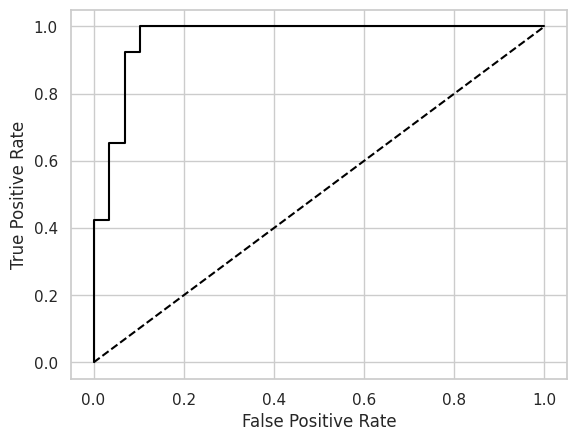

In [16]:
pipeline.fit(X_train, y_train)

print(f'Test accuracy: {pipeline.score(X_test, y_test):.2%}')

y_pred_proba = pipeline.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

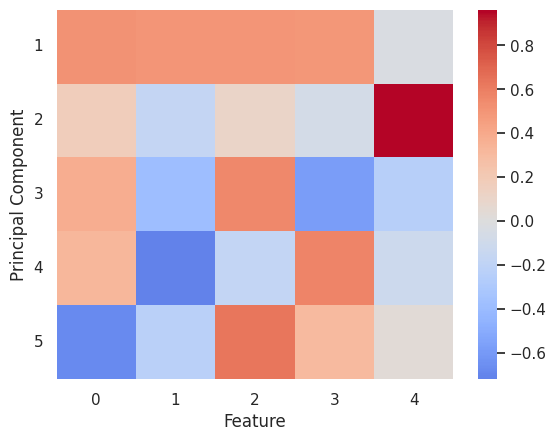

Regression = -1.82 * PC1 + -0.03 * PC2 + -1.38 * PC3 + 0.70 * PC4 + 0.36 * PC5 + -0.55


In [17]:
pca = pipeline.named_steps['pca']

principal_components = pca.components_
sns.heatmap(principal_components, cmap='coolwarm', center=0)
plt.yticks(np.arange(0, len(principal_components))+0.5, range(1, len(principal_components) + 1), rotation=0)
plt.xlabel('Feature')
plt.ylabel('Principal Component')
plt.show()

regression_coefficients = pipeline.named_steps['log_reg'].coef_
regression_intercept = pipeline.named_steps['log_reg'].intercept_

print(f'Regression = {" + ".join([f"{coefficient:.2f} * PC{idx+1}" for idx, coefficient in enumerate(regression_coefficients[0])])} + {regression_intercept[0]:.2f}')

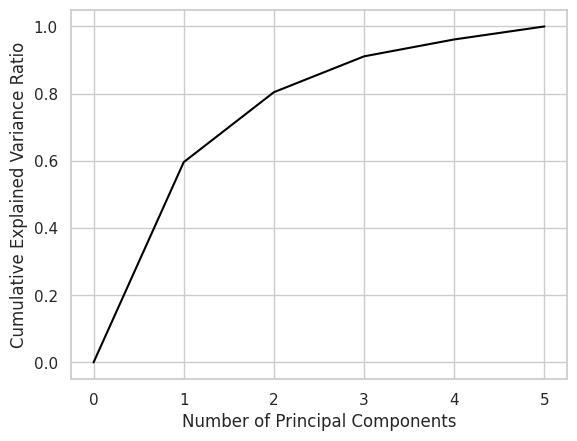

In [18]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

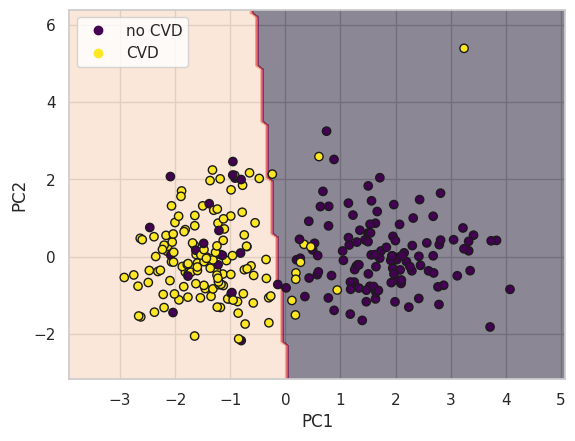

In [19]:
X_reduced = pipeline.named_steps['scaler'].transform(X)
X_reduced = pipeline.named_steps['pca'].transform(X_reduced)
X_reduced = X_reduced[:,:2]

model = clone(pipeline.named_steps['log_reg'])
model.fit(X_reduced, y)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD']);

In [20]:
df.describe()

,deuteranomaly-1-0.25,deuteranomaly-1-1,deuteranomaly-3-0.25,deuteranomaly-3-1,grey,group,severity
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,0.420715,0.491308,0.444746,0.514121,0.204330,3.988930,0.383875
std,0.129596,0.139815,0.152298,0.151306,0.042144,2.588412,0.388862
min,0.204683,0.200943,0.146792,0.240261,0.115952,0.000000,0.000000
25%,0.322461,0.371719,0.318437,0.391782,0.177006,2.000000,0.000000
50%,0.389012,0.474680,0.394751,0.506433,0.200360,4.000000,0.600000
75%,0.518335,0.617318,0.576716,0.631174,0.223645,6.000000,0.760000
max,0.817289,0.788700,0.809234,0.936260,0.419146,8.000000,0.990000


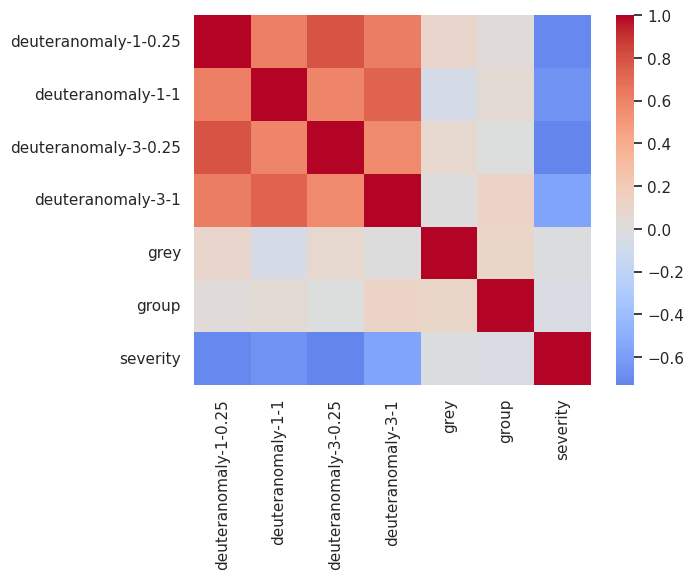

In [21]:
sns.heatmap(df.corr(), cmap='coolwarm', center=0);

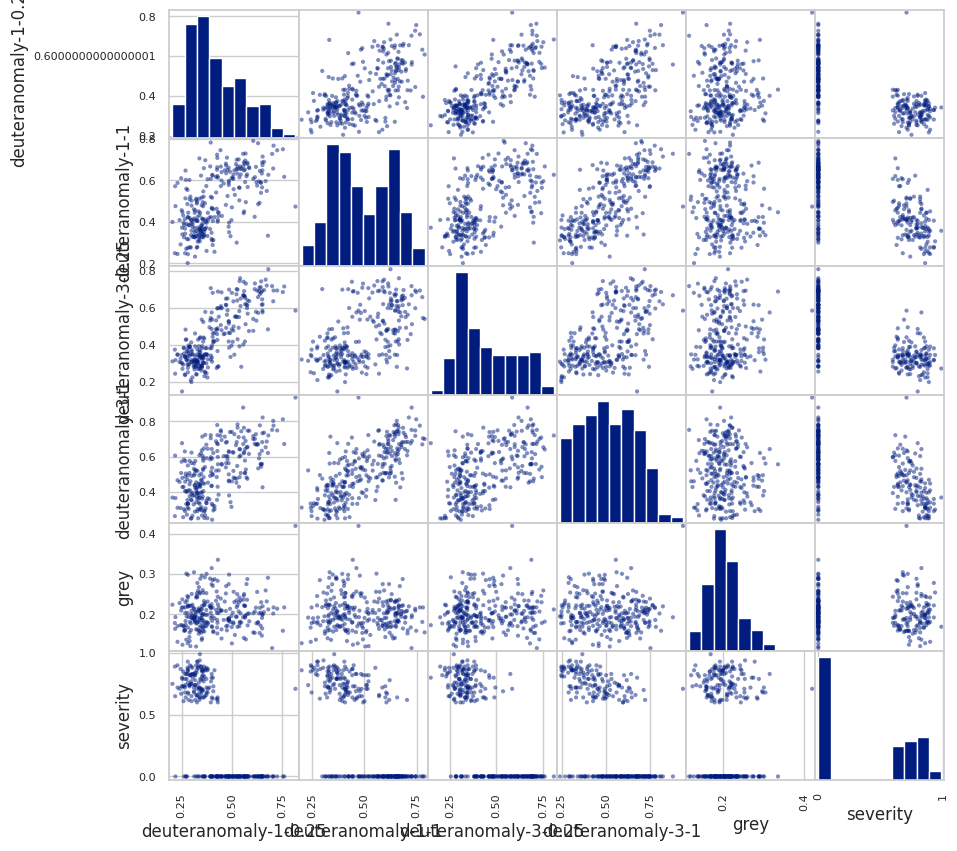

In [22]:
pd.plotting.scatter_matrix(df.drop(columns='group'), figsize=(10, 10));